In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
preds_anss_baseline = np.load("mroberta_baseline/preds_anss_whole.npz")

anss_baseline = preds_anss_baseline["anss"]
preds_baseline = preds_anss_baseline["preds"]

In [3]:
preds_anss_num_encode = np.load("KCroberta_multip/KC_preds_anss_run2.npz")

anss_num_encode = preds_anss_num_encode["anss"]
preds_num_encode = preds_anss_num_encode["preds"]

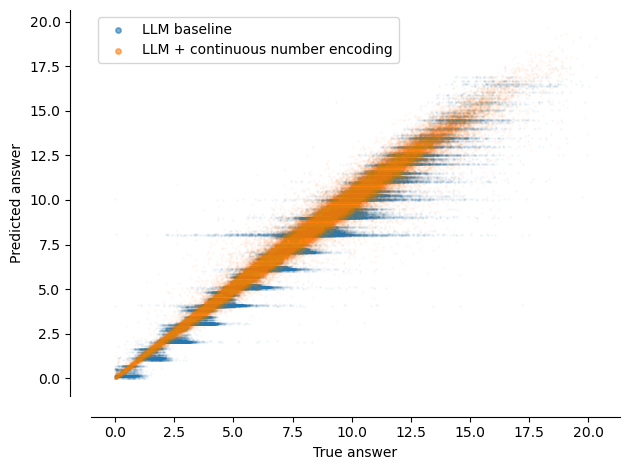

In [4]:
# plt.figure(figsize=(4, 3))

plt.scatter(anss_baseline, preds_baseline, alpha=0.03, s=1)
plt.scatter(anss_num_encode, preds_num_encode, alpha=0.03, s=1)

# create circle for legend
plt.scatter([], [], c='tab:blue', alpha=0.6, s=15, label='LLM baseline')
plt.scatter([], [], c='tab:orange', alpha=0.6, s=15, label='LLM + continuous number encoding')

sns.despine(offset=15)
plt.legend()
plt.xlabel("True answer")
plt.ylabel("Predicted answer")
# plt.title("LLM baseline vs LLM with number encoding")
plt.tight_layout()
# save in a format that is more efficient because of high number of points
plt.savefig("artifacting.png", dpi=300, bbox_inches='tight')

In [5]:
# loading KCencode model and tokenizer

from transformers import PreTrainedTokenizerFast
from datasets import DatasetDict
import torch

# add path to KCroberta_multip
import sys
sys.path.append("./KCroberta_multip/")

best_run_path = "/mnt/home/sgolkar/ceph/saves/xslorenz/KCroberta/wandb/run-20230607_121929-9f6hgi8s/files/model/model_torch_save.pkl"

KCmodel = torch.load(best_run_path).cuda()
KCmodel.eval()

KCtokenizer = PreTrainedTokenizerFast(
    tokenizer_file="KCroberta_multip/toKCenizer_lorenz.json",
    bos_token="[END]",
    eos_token="[END]",
    mask_token="?",
    pad_token="[PAD]",
)

KCvocab_size = len(KCtokenizer.vocab)

KCnum_token = KCtokenizer.encode('#')[0]
KCmask_token = KCtokenizer.encode('?')[0]


# defining the KC predict function
def KCpredict(model, masked_sample, device = 'cuda'):
    model.to(device)
    out = model(
            input_ids = torch.tensor(masked_sample['input_ids']).view(1,-1).to(device),
            labels = torch.tensor(masked_sample['labels']).view(1,-1).to(device),
            numbers = torch.tensor(masked_sample['masked_numbers']).view(1,-1).to(device),
            masked_numbers = torch.tensor(masked_sample['masked_numbers']).view(1,-1).to(device)
            )
    return out

import re

reg_ex = r"(-\d+\.\d+e-\d+)|(-\d+\.\d+e\d+)|(\d+\.\d+e-\d+)|(\d+\.\d+e\d+)|(-\d+e-\d+)|(-\d+e\d+)|(\d+e-\d+)|(\d+e\d+)|(-\d+\.\d+)|(\d+\.\d+)|((?<!sys)\d+)"


def replace_numbers(text):
    text = re.sub(reg_ex, "#", text)
    return text


def find_numbers(text):
    return [eval("".join(el)) for el in re.findall(reg_ex, text)]

max_len = 1150
def KCtokenize_fnc(sample):
    text = sample["text"].replace(" ", "")
    replaced_text = replace_numbers(text)
    out = KCtokenizer(replaced_text)
    ids = np.array(out["input_ids"])
    ids = np.pad(ids, (0, max_len - len(ids)), "constant", constant_values=-1)
    locs = ids == KCnum_token
    num_embed = np.ones(max_len).astype(np.float16)
    num_embed[locs] = find_numbers(text)
    out["numbers"] = num_embed
    return out

import copy
def KCmask_nth_param(sample, n = 10, device = 'cpu'):
    masked_sample = copy.deepcopy(sample)
    masked_sample['input_ids'][n] = KCmask_token
    len_ = len(masked_sample['input_ids'])
    masked_sample['masked_numbers'] = copy.deepcopy(sample['numbers'])[:len_]
    masked_sample['numbers'] = masked_sample['numbers'][:len_]
    masked_sample['labels'] = sample['input_ids']
    masked_sample['masked_numbers'][n] = 1.0
    # Next two lines are for calculating the correct mlm loss
    # tells the model to only look at the masked token for calculating x-entropy
    masked_sample['labels'] = list(0*np.array(masked_sample['labels'])-100)
    masked_sample['labels'][n] = sample['input_ids'][n]
    masked_sample['text'] = KCtokenizer.decode(sample['input_ids'])
    masked_sample['masked_text'] = KCtokenizer.decode(masked_sample['input_ids'])
    masked_sample['ans'] = masked_sample['numbers'][n].item()
    
    return masked_sample

In [9]:
# loading the baseline model and tokenizer

device = 'cuda'

from transformers import RobertaForMaskedLM, PreTrainedTokenizerFast, pipeline
from datasets import DatasetDict

best_run_path = "/mnt/home/sgolkar/ceph/saves/xslorenz/mroberta/wandb/run-20230531_162250-rw7ta38d/files/model/checkpoint-500000"

BLmodel = RobertaForMaskedLM.from_pretrained(best_run_path).to(device)


BLtokenizer = PreTrainedTokenizerFast(
    tokenizer_file="mroberta_baseline/tokenizer_lorenz.json",
    bos_token="[END]",
    eos_token="[END]",
    mask_token="?",
    pad_token="[PAD]",
)

# defining the mask filling pipeline
BLmask_filler = pipeline("fill-mask", model=BLmodel, tokenizer=BLtokenizer, device=0)

In [32]:
# add parent directory to path
sys.path.append("../")
sys.path.append("../../chaospy/")

# suppress python warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import microcosm
import pandas as pd

device = 'cuda'

data = {'correct':[], 'KC':[], 'BL':[]}

for seed in range(6):
    for step_multip in range(1,48):

        text_sample = {}
        text_sample['text'] = str(microcosm.sample_world(
                to_list=True,
                graceful_fail=True,
                seed=seed,
                num_steps=40,
                max_dim=10,
                max_sys=2,
                step_multip=step_multip
            )).replace(' ','')

        KCsample = KCtokenize_fnc(text_sample)

        KCmasked_sample = KCmask_nth_param(KCsample, 33, device)

        correct_answer = KCmasked_sample['numbers'][33].item()
        out = KCpredict(KCmodel, KCmasked_sample, device)
        KC_answer = out.numbers[0,33].item()

        BLsample = text_sample['text']
        split1 = text_sample['text'].split("'step_multip':",1)
        split2 = split1[1].split('}',1)
        BLmasked_sample = split1[0] + "'step_multip':" + '?}' + split2[1]
        BL_answer = float(BLmask_filler(BLmasked_sample)[0]['token_str'])

        data['correct'].append(correct_answer)
        data['KC'].append(KC_answer)
        data['BL'].append(BL_answer)

df = pd.DataFrame(data)

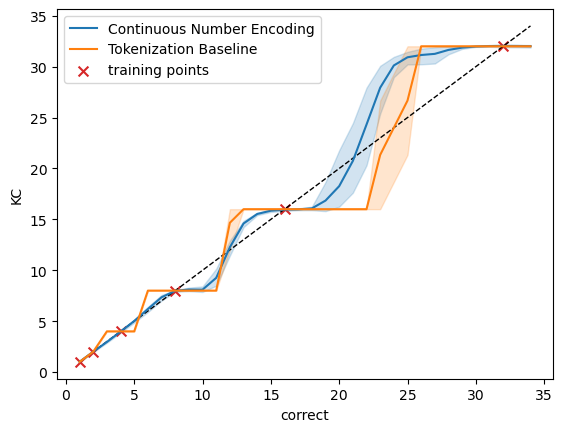

In [51]:
import seaborn as sns

df_to_plot = df.query("correct < 35")

plt.plot([1, 34], [1, 34], color='black', linestyle='dashed', linewidth=1)
sns.lineplot(data=df_to_plot, x="correct", y="KC", errorbar=('ci', 95), label="Continuous Number Encoding")
sns.lineplot(data=df_to_plot, x="correct", y="BL", errorbar=('ci', 95), label="Tokenization Baseline")
plt.scatter([1,2,4,8,16,32], [1,2,4,8,16,32], color='tab:red', marker='x', s=50, label="training points")
plt.legend()

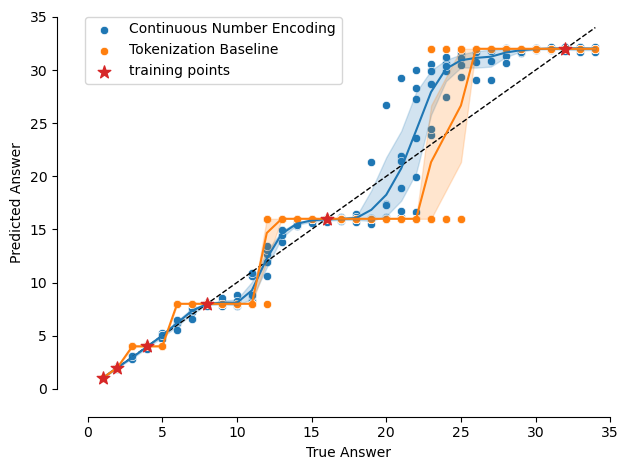

In [65]:
import seaborn as sns

df_to_plot = df.query("correct < 35")

plt.plot([1, 34], [1, 34], color='black', linestyle='dashed', linewidth=1)
sns.scatterplot(data=df_to_plot, x="correct", y="KC", label="Continuous Number Encoding", )
sns.scatterplot(data=df_to_plot, x="correct", y="BL", label="Tokenization Baseline")
# scatter plot showing the mean line and 95% confidence interval
sns.lineplot(data=df_to_plot, x="correct", y="KC", errorbar=('ci', 95), label=None)
sns.lineplot(data=df_to_plot, x="correct", y="BL", errorbar=('ci', 95), label=None)
plt.scatter([1,2,4,8,16,32], [1,2,4,8,16,32], color='tab:red', marker='*', s=90, label="training points", zorder=10)
plt.legend()
sns.despine(offset = 15, trim = True)
plt.xlabel("True Answer")
plt.ylabel("Predicted Answer")
plt.tight_layout()
plt.savefig("quantization.png", dpi=300, bbox_inches='tight')

In [23]:
# seaborn scatter plot showing the mean line and 95% confidence interval
import seaborn as sns


4.0